In [25]:
import os
import cv2
import editdistance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook as tqdm

/home/rob/anaconda3/envs/hwrtf/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# don't use yolo labels


In [33]:
fps = []
preds = []
with open('01. Zooniverse/zooniverse_predictions.txt','r') as f:
    for line in f.readlines():
        exec('line = [' + line.replace('] [','],[').replace('] None [','], None, [') + ']')
        for i in range(len(line)):
            if i == 0:
                fps += line[i]
            elif i == 1:
                preds += line[i]
        if len(fps) != len(preds):
            print('wtf')
len(fps),len(preds)
preds = pd.DataFrame(np.array([fps,preds]).T,columns=['fp','pred'])
preds['cat_no'] = preds['fp'].map(lambda x: x.split('/')[7].split('_')[0])
preds = preds[['cat_no','pred','fp']]
preds['gt'] = np.nan
preds['score'] = np.nan
zoo_preds = preds
zoo_preds.head()
gt = pd.read_csv('01. Zooniverse/zooniverse_transcriptions.csv',index_col=[0,1]).swaplevel(0,1)
gt = gt[gt['#agree_fuzz']>=2][['best_fuzz','#agree_fuzz']].reset_index().rename(columns={'level_1':'label'})
zoo_gt = get_best_pred_for_gts(gt,zoo_preds)

In [34]:
zoo_gt

,subject_ids,label,best_fuzz,#agree_fuzz,pred,pred_score,dist,n,pred_fp
0,219401,coll,Mus. Hauschild,6.0,pragas,21.0,12.0,14.0,/home/rob/HWR/datasets/zooniverse/words/219401...
1,219402,coll,Coll. V. Thomsen,2.0,Mitieon,19.0,14.0,16.0,/home/rob/HWR/datasets/zooniverse/words/219402...
2,219407,coll,Coll. V. Thomsen,2.0,NaN,NaN,16.0,16.0,NaN
3,219408,coll,Coll. Klöcker,2.0,NaN,NaN,13.0,13.0,NaN
4,219409,coll,Coll. Klöcker,2.0,Wrledais,21.0,12.0,13.0,/home/rob/HWR/datasets/zooniverse/words/219409...
5,219410,coll,Coll. Klöcker,2.0,NaN,NaN,13.0,13.0,NaN
6,219411,coll,Coll. S. Doblmann,2.0,bobteasts,33.0,15.0,17.0,/home/rob/HWR/datasets/zooniverse/words/219411...
7,219412,coll,coll. S. Dohlmann,6.0,NaN,NaN,17.0,17.0,NaN
8,219413,coll,Coll. S. Dohlmann,2.0,NaN,NaN,17.0,17.0,NaN
9,219423,coll,'coll.' R.H. Stamm,6.0,NaN,NaN,18.0,18.0,NaN


In [40]:
zoo_gt[zoo_gt['pred_fp']==fp].iloc[0]

subject_ids                                               219543
label                                                        day
best_fuzz                                                     10
#agree_fuzz                                                    2
pred                                                          1w
pred_score                                                    50
dist                                                           1
n                                                              2
pred_fp        /home/rob/HWR/datasets/zooniverse/words/219543...
Name: 4668, dtype: object

       subject_ids      label best_fuzz  #agree_fuzz      pred  pred_score  \
2377        220152        loc  Veddinge          6.0  leddinge        88.0   
5130        220152        day        25          6.0       NaN         NaN   
7946        220152      month         6          6.0    1-6-0g        29.0   
13197       220152  collector       PB.          6.0       NaN         NaN   

       dist    n                                            pred_fp  
2377    1.0  8.0  /home/rob/HWR/datasets/zooniverse/words/220152...  
5130    NaN  2.0                                                NaN  
7946    5.0  1.0  /home/rob/HWR/datasets/zooniverse/words/220152...  
13197   NaN  3.0                                                NaN  


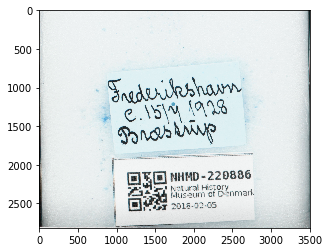

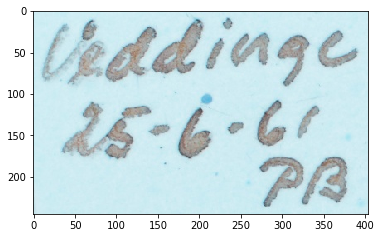

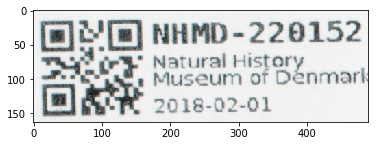

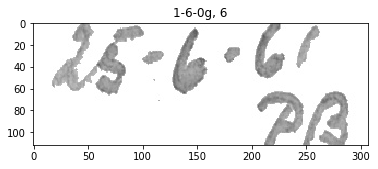

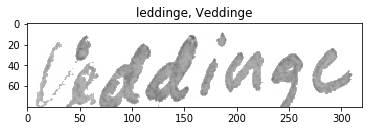

In [88]:

#orig_fps = glob('/home/rob/HWR/datasets/zooniverse/*/Cropped*.jpg')
#orig_fp = np.random.choice(orig_fps)
_id = 220152#orig_fp.split('/')[6]

label_fps = glob('/home/rob/HWR/datasets/zooniverse/yolo_labels/%s*.jpg'%_id)#glob('/home/rob/HWR/datasets/zooniverse/%s/Label*.jpg'%_id)
word_fps = glob('/home/rob/HWR/datasets/zooniverse/words/%s*.jpg'%_id)

orig = cv2.imread(orig_fp)

plt.figure()
plt.imshow(orig)
for fp in label_fps:
    label = cv2.imread(fp)
    plt.figure()
    plt.imshow(label)
    cv2.imwrite('/home/rob/Downloads/words/%s'%fp.split('/')[-1],label)
    
for fp in word_fps:
    word = cv2.imread(fp)
    prediction = zoo_preds[zoo_preds['fp']==fp].iloc[0]['pred']
    
    if len(zoo_gt[zoo_gt['pred_fp']==fp]):
        assigned_gt = zoo_gt[zoo_gt['pred_fp']==fp].iloc[0]['best_fuzz']
    else:
        assigned_gt = ''
    plt.figure()
    plt.imshow(word)
    plt.title(str(prediction) + ', ' + str(assigned_gt))
    cv2.imwrite('/home/rob/Downloads/words/%s'%fp.split('/')[-1],word)
print(zoo_gt[zoo_gt['subject_ids']==int(_id)])

In [ ]:
a = 'slavelsest'
b = ''


In [32]:
def get_best_pred_for_gts(gt,preds):
    gt['pred'] = np.nan
    gt['pred_score'] = np.nan
    gt['dist'] = np.nan
    gt['n'] = np.nan
    gt['pred_fp'] = np.nan
    i=0
    for name,row in tqdm(gt.iterrows(),total=len(gt)):
        gtText = row['best_fuzz']
        cat_no = row['subject_ids']
        possible_preds = preds[preds['cat_no'] == str(cat_no)]['pred'].values
        possible_pred_fps = preds[preds['cat_no'] == str(cat_no)]['fp'].values
        
        best_score = 0
        best_gt = ''
        if len(possible_preds):
            for k in range(len(possible_preds)):
                possible_pred = possible_preds[k]
                possible_pred_fp = possible_pred_fps[k]
                score = fuzz.token_sort_ratio(gtText,possible_pred)
                #print(pred, possible_gt, score)
                if score > best_score:
                    gt.loc[name,'pred'] = possible_pred
                    gt.loc[name,'pred_score'] = score
                    gt.loc[name,'dist'] = editdistance.eval(possible_pred,gtText)
                    gt.loc[name,'n'] = len(gtText)
                    gt.loc[name,'pred_fp'] = possible_pred_fp
                    best_score = score
        else:
            gt.loc[name,'dist'] = editdistance.eval('',gtText)

        gt.loc[name,'n'] = len(gtText)
        #print(gtText,possible_preds,best_score,gt.loc[name,'pred'])
        i+=1
        #if i ==100:
        #    break
    return gt


In [ ]:
get